In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, accuracy_score
import plotting
import joblib

from sklearn.datasets import fetch_openml
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, Y = data['data'].to_numpy(), data['target'].to_numpy()

In [2]:
print(data['feature_names'])
print(X.shape, Y.shape)
print(Y[:12])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
['g' 'w' 't' 'z' 'w' 'w' 't' 'g' 'z' 'g' 't' 'q']


In [3]:
LE = LabelEncoder()
Y = LE.fit_transform(Y)
Y[:12]

array([0, 3, 2, 4, 3, 3, 2, 0, 4, 0, 2, 1])

In [4]:
Y = to_categorical(Y, 5)
Y[:12]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [5]:
Y=2*Y-1
Y[:12]

array([[ 1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1.],
       [-1., -1.,  1., -1., -1.],
       [-1., -1., -1., -1.,  1.],
       [-1., -1., -1.,  1., -1.],
       [-1., -1., -1.,  1., -1.],
       [-1., -1.,  1., -1., -1.],
       [ 1., -1., -1., -1., -1.],
       [-1., -1., -1., -1.,  1.],
       [ 1., -1., -1., -1., -1.],
       [-1., -1.,  1., -1., -1.],
       [-1.,  1., -1., -1., -1.]], dtype=float32)

In [6]:
train_ratio = 0.6
val_ratio = 0.392
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
scaler = StandardScaler().fit(X_train_val)
del X_train_val
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))


Partition the data set into train/val/test: 0.60/0.39/0.01
X_train.shape: (497999, 16)
Y_train.shape: (497999, 5)
X_val.shape: (325360, 16)
Y_val.shape: (325360, 5)
X_test.shape: (6641, 16)
Y_test.shape: (6641, 5)


In [ ]:
model = tf.keras.Sequential()
model.add(layers.InputLayer(input_shape = (16,), name = 'input'))
model.add(layers.Dense(64, name = 'fc1'))
model.add(layers.Activation('relu', name = 'relu1'))
model.add(layers.Dense(32, name = 'fc2'))
model.add(layers.Activation('relu', name = 'relu2'))
model.add(layers.Dense(32, name = 'fc3'))
model.add(layers.Activation('relu', name = 'relu3'))
model.add(layers.Dense(5 , name = 'output'))
model.add(layers.Activation('softmax', name = 'softmax'))
model.summary()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [ ]:
history = model.fit(X_train, Y_train,
                    epochs = 20,
                    validation_data = (X_val, Y_val),
                    batch_size = 1024,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, mode = "min")
                    ])

In [ ]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
model.save('model')

In [ ]:
model = tf.keras.models.load_model('model')
model.summary()

In [ ]:
Y_pred = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))))

In [ ]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0} tagger, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.001, 1)
    plt.grid(True)
    plt.legend(loc='best')  
    
plt.figure(figsize=(6, 6))
plot_roc(Y_test, Y_pred, LE.classes_)

In [ ]:
LE.classes_

In [ ]:
Y_pred.shape

In [ ]:
@@@

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=6)
pca.fit(X_test)
X_test = pca.transform(X_test)
X_test.shape

In [7]:
from pysr import PySRRegressor
model_pysr = PySRRegressor.from_file("hall_of_fame_2022-10-12_010432.685.pkl")

Checking if hall_of_fame_2022-10-12_010432.685.pkl exists...
Loading model from hall_of_fame_2022-10-12_010432.685.pkl


In [ ]:
from pysr import PySRRegressor

model_pysr = PySRRegressor(
    model_selection="accuracy",
    niterations=40,
    timeout_in_seconds=60*60*5,
    maxsize=40,
    select_k_features=6,
    binary_operators=["+", "-", "*"],
    unary_operators=[
        "sin",
        "cos",
        "exp",
        "square",
        "cube"
    ],
    #loss="loss(x, y) = (x - y)^2"
    loss="L2MarginLoss()" # (1 - y * y')^2
    #loss="loss(x, y) = (1 - x * y)^8"
)

In [ ]:
model_pysr.fit(X_test, Y_test)

In [8]:
print(model_pysr)

PySRRegressor.equations_ = [
[
	    pick         score                                           equation  \
	0         0.000000e+00                                         -0.5961421   
	1         2.802959e-02                               sin(x15 - 1.0025682)   
	2         5.548019e-02                         sin(sin(x15) + -0.7922725)   
	3         3.374547e-01                       sin((x15 - x2) + -0.9439041)   
	4         1.483364e-03                 sin((x15 - sin(x2)) + -0.97032344)   
	5         5.514391e-02         cos((3.8239746 - (x2 * 0.76815206)) + x15)   
	6         9.374956e-03  sin(((x15 - x2) - (x14 * -0.2699054)) + -0.874...   
	7         1.450878e-02  sin(((-0.5667273 - ((x14 + x15) * -0.5667273))...   
	8         1.565929e-02  sin(sin((-0.5667273 - ((x14 + x15) * -0.566727...   
	9         2.025300e-03  sin(sin((-0.5667273 - ((x14 + x15) * sin(-0.56...   
	10        1.322615e-02  sin(sin((-0.9503819 - (((x14 + 0.83946085) + x...   
	11        9.294743e-04  sin(sin(

In [17]:
for i in range(5):
    print("Tagger {} = ".format(i)+str(model_pysr.sympy()[i])+"\n------------------------------------------")

Tagger 0 = sin(2.483543*sin(sin(0.67945530451464*x14 + 0.4277928*x15 - x2 + 0.25166250451464*cos((cos(x14**4)**3 - 0.34814203)**2) + 0.25166250451464*cos(exp(1.89585760043374*x14))**2 - 0.79229045)))
------------------------------------------
Tagger 1 = -sin(sin(((x15 - 0.81150883)*sin(0.0568290853525509*x11**3 - sin(1.2576073*x14) + sin(exp(-sin(0.6552834*x11**2)))) + 0.9987689)*cos(sin(cos(x14)))**2) + sin(sin(2*x14)) + 0.9533578)
------------------------------------------
Tagger 2 = cos(1.2143873*sin((x2 + exp(2*cos(1.2848912*x14)**3) - sin(exp(cos(0.21833353*x14)**3)))*sin(sin(-x14 + x3 + 0.25042366))) + sin(sin(sin(sin(x3)))) - 2.2397704)
------------------------------------------
Tagger 3 = sin((-x15 + exp(-sin(sin(x3 - cos(x2 + 2.65310114714028*exp(sin(9.75160815829225*(-0.320229899449413*x3 - 1)**2)))))))*sin(cos(x14 + 0.28912926*sin(sin(x3)))**108 + 0.07835032) - 7.396321)
------------------------------------------
Tagger 4 = cos(exp(cos((-0.6879885*x15 + exp(-x3 + sin((-x3 + 

In [10]:
Y_pysr=model_pysr.predict(X_test)

In [11]:
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pysr, axis=1))))

Accuracy: 0.744165035386237


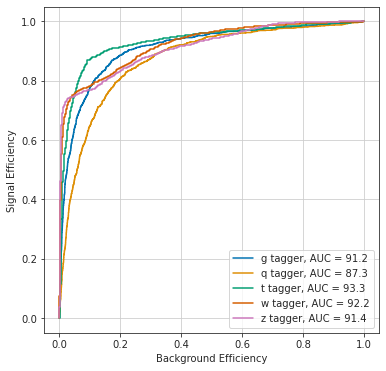

In [12]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0} tagger, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.001, 1)
    plt.grid(True)
    plt.legend(loc='best')  
    
plt.figure(figsize=(6, 6))
plot_roc(Y_test, Y_pysr, LE.classes_)

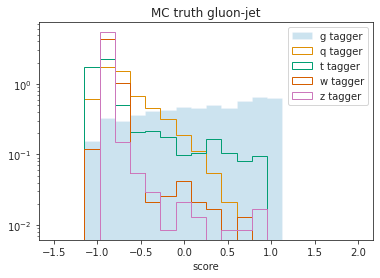

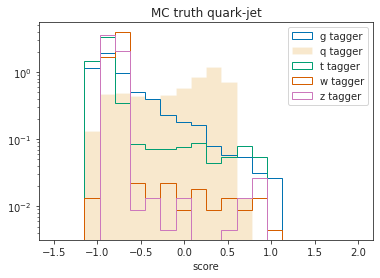

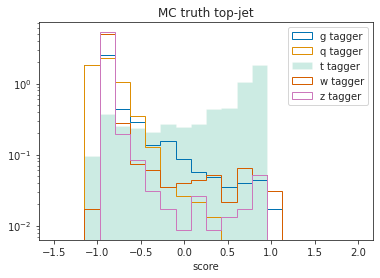

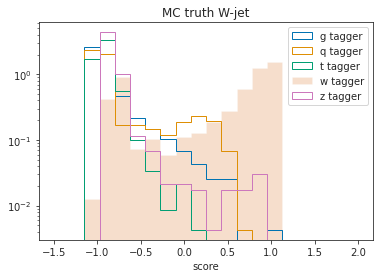

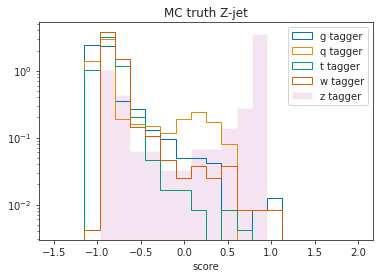

In [14]:
nbins=20
rmin=-1.5
rmax=2
plt.hist(Y_pysr[Y_test[:,0]==1,0], bins=nbins, range=(rmin,rmax), density=1, histtype='stepfilled', alpha=0.2, label='g tagger', log=True)
plt.hist(Y_pysr[Y_test[:,0]==1,1], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='q tagger')
plt.hist(Y_pysr[Y_test[:,0]==1,2], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='t tagger')
plt.hist(Y_pysr[Y_test[:,0]==1,3], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='w tagger')
plt.hist(Y_pysr[Y_test[:,0]==1,4], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='z tagger')
plt.legend(loc='best')
plt.title('MC truth gluon-jet')
plt.xlabel('score')
plt.show()

plt.hist(Y_pysr[Y_test[:,1]==1,0], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='g tagger', log=True)
plt.hist(Y_pysr[Y_test[:,1]==1,1], bins=nbins, range=(rmin,rmax), density=1, histtype='stepfilled', alpha=0.2, label='q tagger')
plt.hist(Y_pysr[Y_test[:,1]==1,2], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='t tagger')
plt.hist(Y_pysr[Y_test[:,1]==1,3], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='w tagger')
plt.hist(Y_pysr[Y_test[:,1]==1,4], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='z tagger')
plt.legend(loc='best')
plt.title('MC truth quark-jet')
plt.xlabel('score')
plt.show()

plt.hist(Y_pysr[Y_test[:,2]==1,0], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='g tagger', log=True)
plt.hist(Y_pysr[Y_test[:,2]==1,1], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='q tagger')
plt.hist(Y_pysr[Y_test[:,2]==1,2], bins=nbins, range=(rmin,rmax), density=1, histtype='stepfilled', alpha=0.2, label='t tagger')
plt.hist(Y_pysr[Y_test[:,2]==1,3], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='w tagger')
plt.hist(Y_pysr[Y_test[:,2]==1,4], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='z tagger')
plt.legend(loc='best')
plt.title('MC truth top-jet')
plt.xlabel('score')
plt.show()

plt.hist(Y_pysr[Y_test[:,3]==1,0], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='g tagger', log=True)
plt.hist(Y_pysr[Y_test[:,3]==1,1], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='q tagger')
plt.hist(Y_pysr[Y_test[:,3]==1,2], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='t tagger')
plt.hist(Y_pysr[Y_test[:,3]==1,3], bins=nbins, range=(rmin,rmax), density=1, histtype='stepfilled', alpha=0.2, label='w tagger')
plt.hist(Y_pysr[Y_test[:,3]==1,4], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='z tagger')
plt.legend(loc='best')
plt.title('MC truth W-jet')
plt.xlabel('score')
plt.show()

plt.hist(Y_pysr[Y_test[:,4]==1,0], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='g tagger', log=True)
plt.hist(Y_pysr[Y_test[:,4]==1,1], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='q tagger')
plt.hist(Y_pysr[Y_test[:,4]==1,2], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='t tagger')
plt.hist(Y_pysr[Y_test[:,4]==1,3], bins=nbins, range=(rmin,rmax), density=1, histtype='step', label='w tagger')
plt.hist(Y_pysr[Y_test[:,4]==1,4], bins=nbins, range=(rmin,rmax), density=1, histtype='stepfilled', alpha=0.2, label='z tagger')
plt.legend(loc='best')
plt.title('MC truth Z-jet')
plt.xlabel('score')
plt.show()